# Week 8: Corner Detection


### Date: 30th November, 2023

Last week you learned about corner detection algorithms and how these can be used to find
interesting features on an image that can be used in applications such as stereo matching,
3D reconstruction, tracking, localization and recognition.
Your task today is to code two corner detection algorithms, the Moravec and the Harris
corner detector.

In [1]:
import numpy as np
import copy
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

## Task 1: Moravec corner detector

The Moravec corner detector uses a patch centred on each pixel as its own matching
template. The patch is shifted so that it is centred on each of the 8 neighbours of the pixel
and the sum of squared differences (SSD) is calculated between the original patch and the
shifted patch:

$$
    E = \sum_{\Delta \mathbf{x}} w(\Delta \mathbf{x})\big(I(\mathbf{x} + \Delta \mathbf{x}) - I(\mathbf{x}^{\prime} + \Delta \mathbf{x}\big)^2
$$


$w$ is a weighting function with the same dimension as the patch, you can use a Gaussian or constant weights. The corner metric (cornerness) is then taken to be the minimum of the SSD values calculated for each of the eight shifts of the window.
A pixel is marked as a corner if its cornerness is above a user-specified threshold.


Your task is to write your implementation of the Moravec corner detector.
It will take as input a grayscale image, the window size, the threshold and optionally a Gaussian function for $w$. It will give as output a corner map as a list of pixel coordinates where a corner is detected.


In [6]:
def draw_corners(image, corners_map, color=(255, 0, 0)):
    """Draw a point for each possible corner.
    color image: [H, W, 3]
    corners_map: list of pixel coordinates (xy indexing)
    """
    
    color_img = cv2.cvtColor(image[:,:,0], cv2.COLOR_GRAY2BGR)
    for corner in corners_map:
        cv2.circle(color_img, corner, 1, color, -1)
    return color_img

"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
def get_mean_filter_kernel(h, w):
    return np.ones((h, w)) / (h * w)


def get_gaussian_kernel(h, w, sigma):
    '''
    Get kernel of Gaussian filter
    '''
    assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")

    h_range = np.linspace(-h // 2, h // 2, h)
    w_range = np.linspace(-w // 2, w // 2, w)
    x, y = np.meshgrid(h_range, w_range)
    out_kernel = np.exp(-(x**2 + y**2)/(2 * sigma**2))
    # Diveded by sum to normalize the kernel
    out_kernel /= np.sum(out_kernel)
    return out_kernel


"""
Implement your moravec detector here.
"""
def moravec(img, window_size=3, threshold=100., weights=None):
    """Moravec's corner detection for each pixel of the image.
    image: grayscale image: [H, W]
    """

    assert window_size % 2 == 1, "window size should be an odd number"
    image = img.copy()
    h, w = image.shape
    half_window = window_size // 2
    padding = window_size // 2 + 1
    corners = []

    for y in range(padding, h - padding):
        for x in range(padding, w - padding):
            patch = image[(y - half_window) : (y + half_window + 1), (x - half_window) : (x + half_window + 1)]
            min_ssd = float('inf')
            for dy in range(-1, 2):
                for dx in range(-1, 2):
                    if dx == 0 and dy == 0:
                        continue
                    shifted_patch = image[(y - half_window + dy) : (y + half_window + dy + 1),
                                          (x - half_window + dx) : (x + half_window + dx + 1)]
                    ssd = (patch - shifted_patch)**2
                    if weights is not None:
                        ssd = ssd * weights
                    ssd = np.sum(ssd)
                    min_ssd = min(min_ssd, ssd)
            if min_ssd > threshold:
                corners.append((x, y))
    return corners

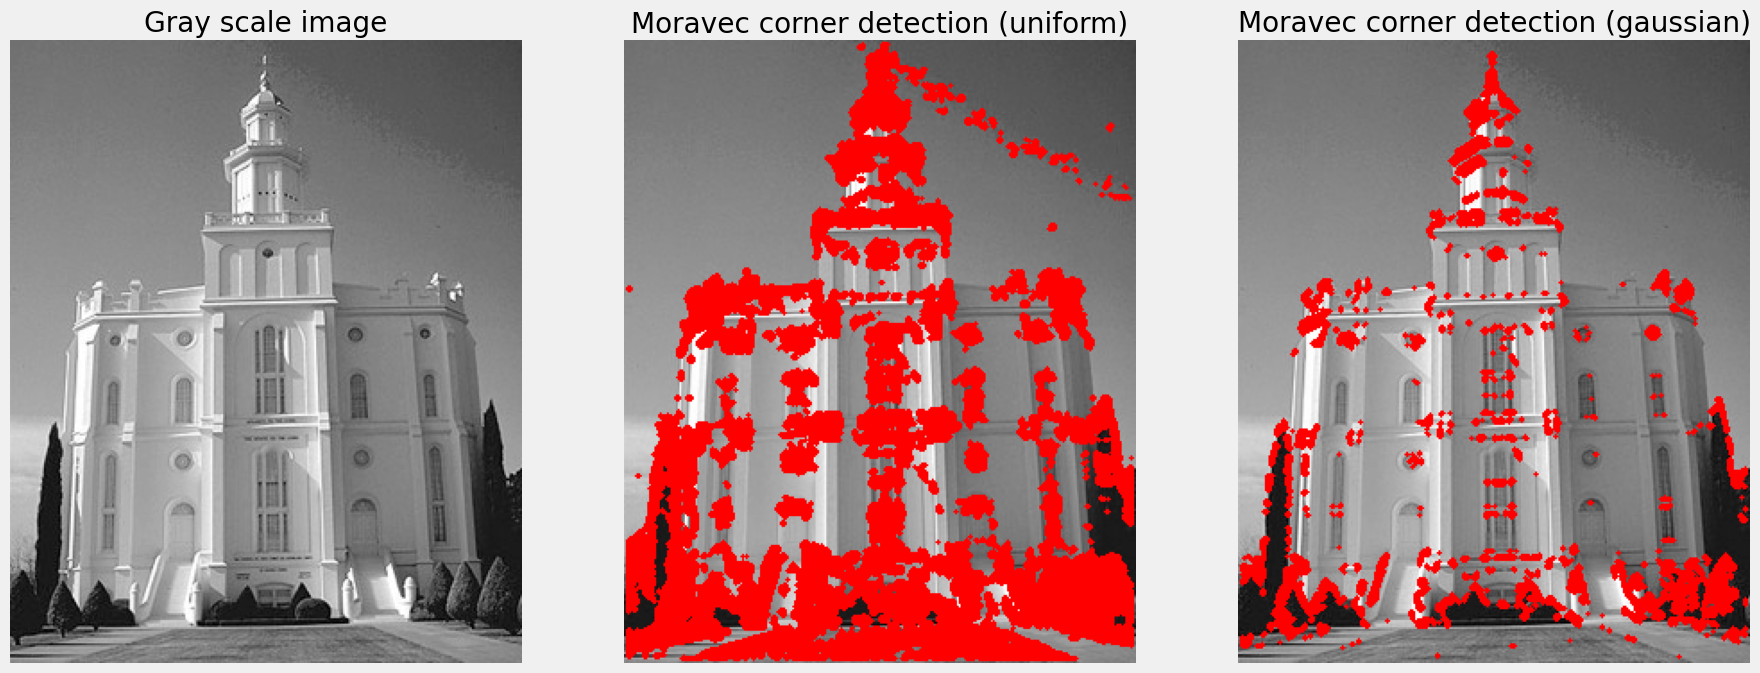

In [8]:
img = cv2.imread('../images/building.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

moravec_corners = moravec(gray_img, threshold=200.)
img_with_corner = draw_corners(img, moravec_corners)

moravec_corners2 = moravec(gray_img, threshold=200., weights=get_gaussian_kernel(3, 3, 1.0))
img_with_corner2 = draw_corners(img, moravec_corners2)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(img_with_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Moravec corner detection (uniform)')
axis[1].set_axis_off()

axis[2].imshow(img_with_corner2, 'gray')
axis[2].grid(False)
axis[2].set_title('Moravec corner detection (gaussian)')
axis[2].set_axis_off()

plt.show()

## Task 2: Harris corner detector

The Harris corner detector builds upon the concepts of the Moravec corner detector, but
overcomes its limitations by generalising the measure of cornerness.
The basic limitation of the Moravec detector is that it only calculates cornerness for the 8 main directions
corresponding to the neighbours of a pixel, which means it will not detect a corner in any other direction.
The Harris detector uses the image structure tensor to overcome this. The image structure tensor is:

$$
    S = 
    \begin{pmatrix}
     I^2_x   & I_x I_y\\
     I_x I_y & I^2_x
    \end{pmatrix}
$$

where $I_x$ is the partial derivative of the image in the x direction and $I_y$ is the partial derivative of the image in the y direction.
The structure tensor summarizes the main directions of the gradient of the image for every pixel and therefore its two eigenvalues can be used to determine whether there is a corner at a pixel (if both eigenvalues are large).
The cornerness response metric is then defined as follows:

$$
    C = \text{det}(S) - k \text{tr}(S)^2 \\
$$

where $k$ is a an empirically determined hyper-parameter, usually in the range of $[0.04, 0.06]$

### Non-maximum Suppression (NMS)

In most cases, naivly thresholding the response map will lead to a lot of false-positives, i.e. blobs around real corners. One way to mitigate this to use Non-maximum Suppression (NMS). There is a number of ways of doing it, but the principle is to only keep the pixel with maxium response for aby local regions. You can try by simply setting pixels that have an 8 neighbour with higher cornerness to zero.

In [75]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
def apply_filter(src_img, kernel):
    img_fft = np.fft.fft2(src_img)
    kernel_fft = np.fft.fft2(kernel, s=src_img.shape)
    img = np.fft.ifft2(img_fft * kernel_fft).real
    return img


def apply_gaussian_filter(src_img, k=5, sigma=1.0):
    kernel = get_gaussian_kernel(k, k, sigma)
    return apply_filter(src_img, kernel)


def gradientX(image, mode="fft"):
    kernel = np.array([[-1., 0., 1.],
                       [-2., 0., 2.],
                       [-1., 0., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image

def gradientY(image, mode="fft"):
    kernel = np.array([[-1., -2., -1.],
                       [0., 0., 0.],
                       [1., 2., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image

def harris(img, window_size=3, threshold=2000., k=0.05, weights=None):
    assert window_size % 2 == 1, "window size should be an odd number"
    image = img.copy()
    h, w = image.shape
    dx = gradientX(image)
    dy = gradientY(image)
    Ixx = dx ** 2
    Iyy = dy ** 2
    Ixy = dx * dy
    padding = window_size // 2
    corners = []
    response = np.zeros_like(img)

    for y in range(padding, h - padding):
        for x in range(padding, w - padding):
            Sxx = Ixx[y - padding : y + padding + 1, x - padding : x + padding + 1]
            Syy = Iyy[y - padding : y + padding + 1, x - padding : x + padding + 1]
            Sxy = Ixy[y - padding : y + padding + 1, x - padding : x + padding + 1]
            if weights is not None:
                Sxx = weights * Ixx[y - padding : y + padding + 1, x - padding : x + padding + 1]
                Syy = weights * Iyy[y - padding : y + padding + 1, x - padding : x + padding + 1]
                Sxy = weights * Ixy[y - padding : y + padding + 1, x - padding : x + padding + 1]
            Sxx = np.sum(Sxx)
            Syy = np.sum(Syy)
            Sxy = np.sum(Sxy)
            S = np.array([[Sxx, Sxy], [Sxy, Syy]])
            r = np.linalg.det(S) - k * np.trace(S) ** 2
            response[y][x] = r
            if r > threshold:
                corners.append((x, y))
    return corners, response

def nms(response, threshold, window_size=3):
    padding = window_size // 2
    h, w = response.shape
    corners = []
    for y in range(padding, h - padding):
        for x in range(padding, w - padding):
            corner = response[y - padding : y + padding + 1, x - padding : x + padding + 1]
            if response[y][x] >= threshold and response[y][x] == np.max(corner):
                corners.append((x, y))
    return corners

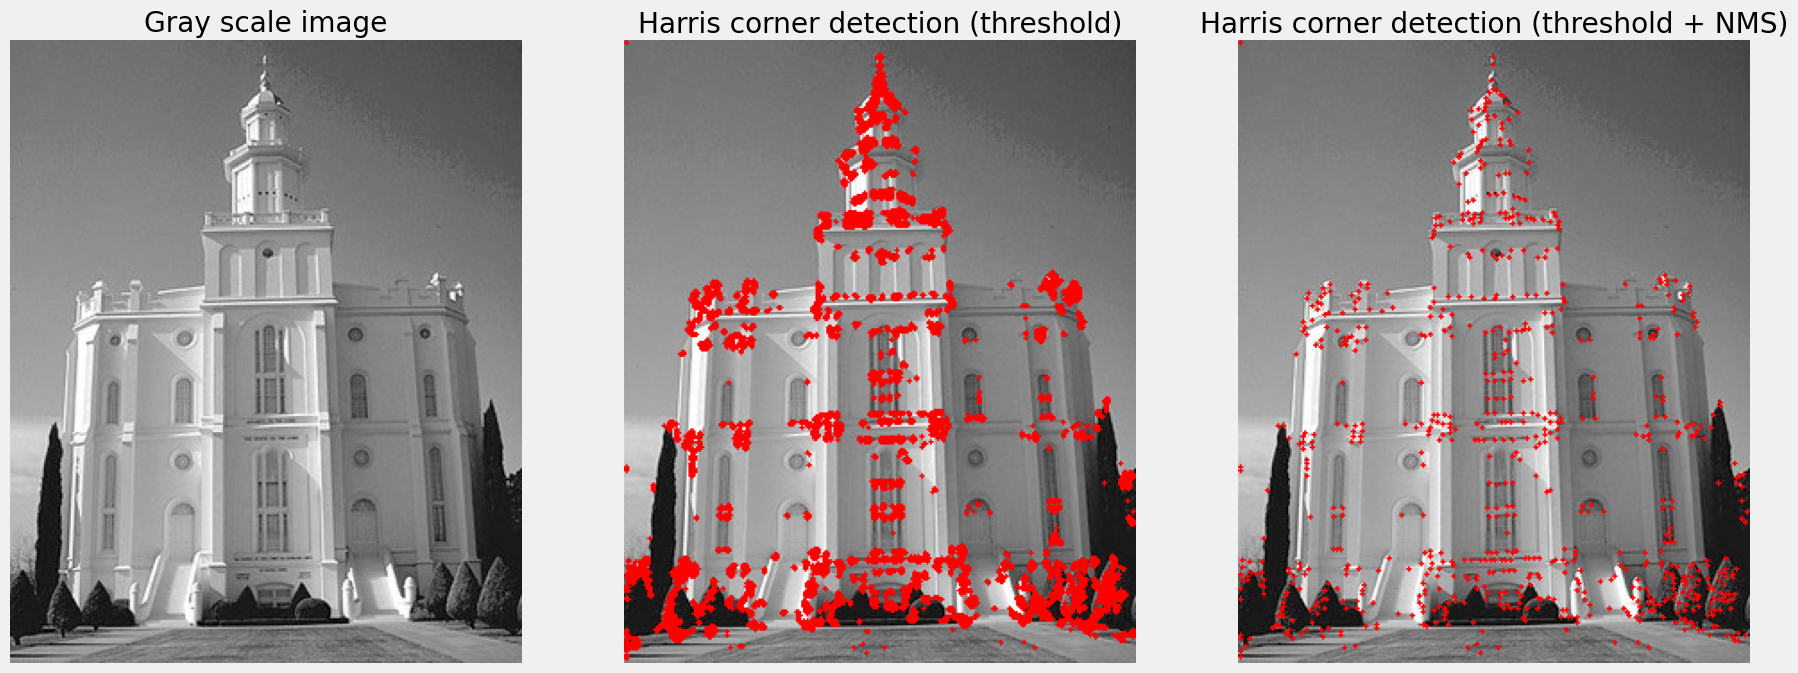

In [76]:
img = cv2.imread('../images/building.png')
k = 0.05
threshold = 2000.
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
H, W = gray_img.shape
# Write your code here:

corners, response = harris(gray_img, threshold=threshold, k=k, weights=get_gaussian_kernel(3, 3, 1.0))
harris_img_corner = draw_corners(img, corners)
# corners after NMS
corners, response = harris(gray_img, threshold=threshold, k=k, weights=get_gaussian_kernel(3, 3, 1.0))
corners_nms = nms(response, threshold)
harris_img_corner_nms = draw_corners(img, corners_nms)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(harris_img_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Harris corner detection (threshold)')
axis[1].set_axis_off()

axis[2].imshow(harris_img_corner_nms, 'gray')
axis[2].grid(False)
axis[2].set_title('Harris corner detection (threshold + NMS)')
axis[2].set_axis_off()

plt.show()